# Stop Hotspot Detection

**MovingPandas & OSMnx making Spaghetti**

Author: Anita Graser

This demo shows how to detect significant hotspots of urban activity.

Based on 

* [Network-constrained spatial autocorrelation by James D. Gaboardi](https://github.com/pysal/spaghetti/blob/8dfec40812a9824e575822a1587b47f26fc45313/notebooks/network-spatial-autocorrelation.ipynb)
* [Simplify network topology and consolidate intersections by Geoff Boeing](https://github.com/gboeing/osmnx-examples/blob/64e104f8e3e719c23c640172c2f18ba7b46a020d/notebooks/04-simplify-graph-consolidate-nodes.ipynb)

In [1]:
import networkx as nx
import osmnx as ox
from osmnx import utils_graph
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
from datetime import timedelta
import spaghetti
import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_moran

%matplotlib inline
ox.config(use_cache=True, log_console=True)
print(ox.__version__)
print(gpd.__version__)
print(mpd.__version__)

0.16.1
0.8.1
0.5.rc1


## Finding stops in movement trajectories

This also serves as a stress test for MovingPandas. The sample dataset contains 190k points. 

In [2]:
tracks_gdf = gpd.read_file('./data/geolife_sample.gpkg')

In [3]:
tracks_gdf['t'] = pd.to_datetime(tracks_gdf['t'])
tracks_gdf = tracks_gdf.set_index('t').tz_localize(None)
traj_collection = mpd.TrajectoryCollection(tracks_gdf, 'trajectory')

In [4]:
%%time
stops = mpd.TrajectoryStopDetector(traj_collection)\
   .get_stop_segments(min_duration=timedelta(seconds=180), max_diameter=100)

Wall time: 5min 3s


In [5]:
stop_pts = stops.get_start_locations()
len(stop_pts)

853

In [6]:
minx, miny, maxx, maxy = stop_pts.geometry.total_bounds

## Preparing the network data

In [7]:
buffer = 0.005
G = ox.graph_from_bbox(maxy+buffer, miny-buffer, minx-buffer, maxx+buffer, network_type='all')

In [8]:
len(G)

3189

In [9]:
G_proj = ox.project_graph(G)
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
G2 = ox.project_graph(G2, to_crs='EPSG:4326')
len(G2)

1698

In [10]:
graph_gdf = gpd.GeoDataFrame(utils_graph.graph_to_gdfs(G2, nodes=False)["geometry"])

<AxesSubplot:>

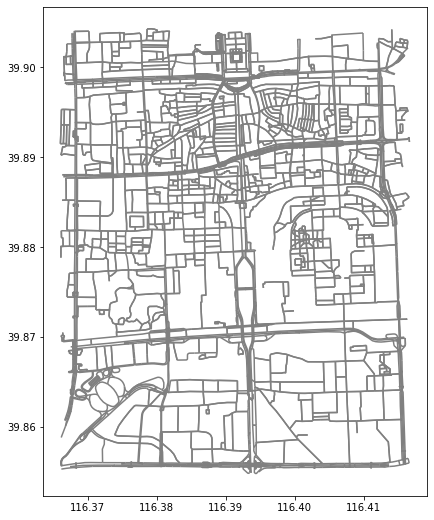

In [11]:
graph_gdf.plot(figsize=(9,9), color='grey')

It's worth noting that there's an area in the east (in the Temple of Heaven park) with a lot of stops but no network coverage. This happend because these areas are modelled as open spaces (highway=pedestrian, area=true) in OSM (https://www.openstreetmap.org/way/29182811).

<AxesSubplot:>

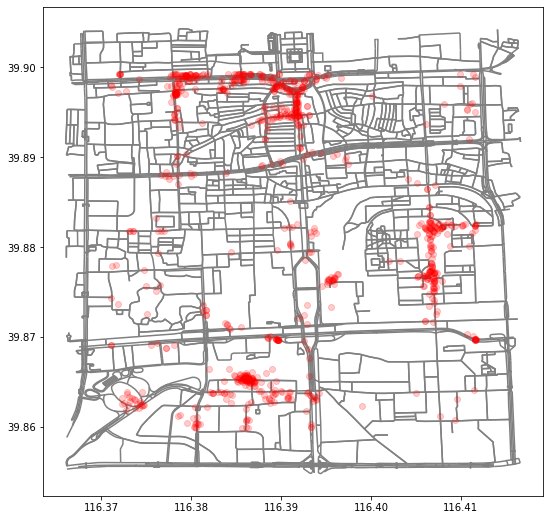

In [12]:
ax = graph_gdf.plot(figsize=(9,9), color='grey', zorder=0)
stop_pts.plot(ax=ax, color='red', zorder=3, alpha=0.2)

## Assigning stops to network edges 

In [13]:
ntw = spaghetti.Network(in_data=graph_gdf)

In [14]:
pp_name = "stops"
ntw.snapobservations(stops.get_start_locations(), pp_name, attribute=True)

## Calculating local statistics

In [15]:
def calc_moran(net, pp_name, w):
    """Calculate a Moran's I statistic based on network arcs."""
    # Compute the counts
    pointpat = net.pointpatterns[pp_name]
    counts = net.count_per_link(pointpat.obs_to_arc, graph=False)
    # Build the y vector
    arcs = w.neighbors.keys()
    y = [counts[a] if a in counts.keys() else 0. for i, a in enumerate(arcs)]
    # Moran's I
    moran = esda.moran.Moran(y, w, permutations=99)
    return moran, y

In [16]:
moran_ntwwn, yaxis_ntwwn = calc_moran(ntw, pp_name, ntw.w_network)

In [17]:
_, arc_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
arc_df['n'] = yaxis_ntwwn

<AxesSubplot:>

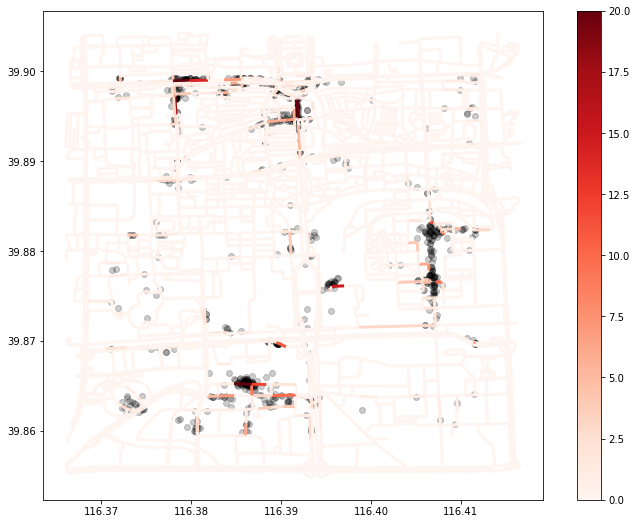

In [18]:
ax = arc_df.plot(column='n', figsize=(12,9), cmap='Reds', legend=True, zorder=3, lw=3, vmax=20)
stop_pts.plot(ax=ax, color='black', alpha=0.2, zorder=0)

In [19]:
moran_loc_ntwwn = esda.moran.Moran_Local(yaxis_ntwwn, ntw.w_network)

<AxesSubplot:>

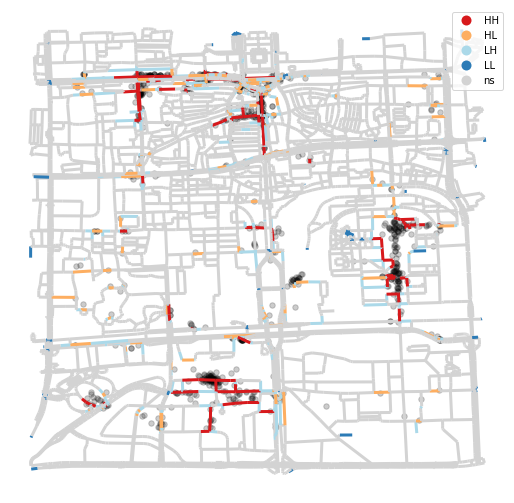

In [20]:
f, ax = lisa_cluster(moran_loc_ntwwn, arc_df, p=0.05, figsize=(9,9), lw=3, zorder=3)
stop_pts.plot(ax=ax, zorder=1, alpha=.2, color="black", markersize=30)